In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# test and train (done)
# TO DO ComposableTimeSeriesForestClassifier (ensamble of trees)
# run primitive model (done)
# good visualization and decoding (test that indeed labels are good), done, looks ok
# Decode back from input to tickerrs (done)
# fix files update?? It looks like working
# Check metrics and etc. Create funstions for this (done)
# check train data, it looks like something is wrong causing sucn a huge overtraining -> data look alright
# Check mode models from sktime
# check examples.  Create funstions for this
# reverse knowkedge to the ticket
# select best examples
# select actual predictions?
  # prediction sample????

# testing directly tsfresh
  # principal proble is that rolling horizon doesn't have a step
  # indirectly running cruches


# Init

In [ ]:
# !pip install 'scipy==1.5'
!pip install yfinance
# !pip install sktime[all_extras]
# !pip install statsmodels==0.12.1


     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
# from sktime.classification.compose import ComposableTimeSeriesForestClassifier
# from sktime.datasets import load_arrow_head
# from sktime.utils.slope_and_trend import _slope
# from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor


In [ ]:
import pandas as pd
import numpy as np
# import seaborn as sns
import pandas as pd
import datetime
#pd.set_option('display.max_columns', 20)
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.size'] = 17
import os
import numpy as np
import math
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers

from pickle import dump,load

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

# Download all tickets files

In [ ]:
!ls gdrive/MyDrive/richbich/data

america_2021-07-19.csv	hongkong_2021-07-19.csv  uk_2021-07-19.csv
canada_2021-07-19.csv	test3.csv		 us_hist.csv
germany_2021-07-19.csv	test_hist.csv		 working_data


In [ ]:
file_us = "gdrive/MyDrive/richbich/data/america_2021-07-19.csv"
file_can = "gdrive/MyDrive/richbich/data/canada_2021-07-19.csv"
file_ger = "gdrive/MyDrive/richbich/data/germany_2021-07-19.csv"
file_hong = "gdrive/MyDrive/richbich/data/hongkong_2021-07-19.csv"
file_uk = "gdrive/MyDrive/richbich/data/uk_2021-07-19.csv"

df_master_us = pd.read_csv(file_us)
df_master_can = pd.read_csv(file_can)
df_master_ger = pd.read_csv(file_ger)
df_master_hong = pd.read_csv(file_hong)
df_master_uk = pd.read_csv(file_uk)

In [ ]:
tickers_list = list(df_master_can.Ticker.unique())
tickers_list_chunks = chunker(tickers_list, 500)


In [ ]:
l = list(tickers_list_chunks)

In [ ]:
len(l[1:])

5

In [ ]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def download_history(input_df, output_name="test_hist", from_chunk=0, path="gdrive/MyDrive/richbich/data/working_data/"):
  tickers_list = list(input_df.Ticker.unique())

  tickers_list_chunks = chunker(tickers_list, 500)
  list_chunk = list(tickers_list_chunks)
  list_chunk = list_chunk[from_chunk:]

  iterator = 0+from_chunk
  for tickers_chunk in list_chunk:

    print(f'load {iterator} chunk of length {len(tickers_chunk)}')
    print(tickers_chunk)
    data = yf.download(
          tickers = tickers_chunk,
          period = "11y",
          interval = "1d",
          group_by = 'ticker',
          auto_adjust = True,
          threads = True,
          proxy = None
      ).stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
    data.to_csv(f'{path}{output_name}_{iterator}.csv')
    iterator += 1

def update_file(input_file):

  df_input = pd.read_csv(input_file)
  start_date =  pd.to_datetime(df_input.Date).max() + timedelta(days=1)

  print(start_date)
  tickers_list = list(df_input.Ticker.unique())
  data = yf.download(
        tickers = tickers_list,
        start = start_date,
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        threads = True,
        proxy = None
    ).stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

  df_input = df_input.append(data.reset_index(), ignore_index=True)
  return df_input
  # data.to_csv(input_file)


In [ ]:
download_history(df_master_us, 'us_hist', from_chunk=7)

In [ ]:
!ls -sh gdrive/MyDrive/richbich/data/

In [ ]:
!ls -sh gdrive/MyDrive/richbich/data/working_data

total 975M
114M us_hist_0.csv   2.4M us_hist_14.csv   81M us_hist_5.csv
 70M us_hist_10.csv  102M us_hist_1.csv    52M us_hist_7.csv
 63M us_hist_11.csv   91M us_hist_2.csv    60M us_hist_8.csv
 61M us_hist_12.csv   91M us_hist_3.csv    65M us_hist_9.csv
 47M us_hist_13.csv   83M us_hist_4.csv


In [ ]:
df_test2 = update_file('gdrive/MyDrive/richbich/data/working_data/us_hist_9.csv')

In [ ]:
df_test = pd.read_csv('gdrive/MyDrive/richbich/data/working_data/us_hist_9.csv')

In [ ]:
df_test.Ticker.unique()

In [ ]:
df_test[df_test.Ticker == 'ACU'].head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2010-10-14,ACU,NaN,7.895349,7.895349,7.895349,7.895349,0.0
191,2010-10-15,ACU,NaN,7.801451,7.824925,7.746676,7.824925,800.0
360,2010-10-18,ACU,NaN,8.044024,8.098799,7.895351,7.903176,2200.0
530,2010-10-19,ACU,NaN,8.044024,8.044024,8.044024,8.044024,0.0
695,2010-10-20,ACU,NaN,8.051850,8.137924,7.950126,7.957951,1400.0


In [ ]:
df_test2[df_test2.Ticker == 'ACU'].head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2010-10-14,ACU,NaN,7.895349,7.895349,7.895349,7.895349,0.0
191,2010-10-15,ACU,NaN,7.801451,7.824925,7.746676,7.824925,800.0
360,2010-10-18,ACU,NaN,8.044024,8.098799,7.895351,7.903176,2200.0
530,2010-10-19,ACU,NaN,8.044024,8.044024,8.044024,8.044024,0.0
695,2010-10-20,ACU,NaN,8.051850,8.137924,7.950126,7.957951,1400.0


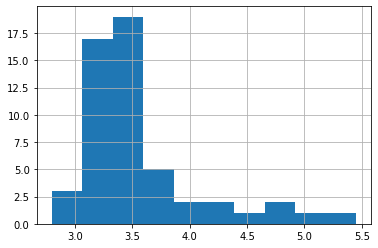

In [ ]:
df_test[df_test.Ticker == 'ZIVO'].Close.hist()

In [ ]:
df_test2[df_test2.Ticker == 'ACAD'].tail(60)

# Update Files

In [ ]:
def update_file(input_file):

  df_input = pd.read_csv(input_file)
  start_date =  pd.to_datetime(df_input.Date).max() + timedelta(days=1)

  print(start_date)
  tickers_list = list(df_input.Ticker.unique())
  data = yf.download(
        tickers = tickers_list,
        start = start_date,
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        threads = True,
        proxy = None
    ).stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

  df_input = df_input.append(data.reset_index(), ignore_index=True)
  # return df_input
  df_input.to_csv(input_file)


# doesn't work properly.....

list_files = !ls gdrive/MyDrive/richbich/data/working_data/us_hist*
for file in list_files:
  print(file)
  update_file(file)

gdrive/MyDrive/richbich/data/working_data/us_hist_0.csv
2021-12-02 00:00:00
[*********************100%***********************]  397 of 397 completed

1 Failed download:
- MXIM: No data found, symbol may be delisted
gdrive/MyDrive/richbich/data/working_data/us_hist_10.csv
2021-12-02 00:00:00
[*********************100%***********************]  495 of 495 completed

18 Failed downloads:
- ARPO: No data found, symbol may be delisted
- ARHH: No data found, symbol may be delisted
- IEC: No data found for this date range, symbol may be delisted
- RIVE: No data found for this date range, symbol may be delisted
- LIVK: No data found, symbol may be delisted
- ITAC: No data found for this date range, symbol may be delisted
- AMHC: No data found, symbol may be delisted
- MAGS: No data found, symbol may be delisted
- SPRT: No data found, symbol may be delisted
- CHFW: No data found, symbol may be delisted
- PTK: No data found, symbol may be delisted
- JMP: No data found for this date range, symbol 

In [ ]:
list_files

['gdrive/MyDrive/richbich/data/working_data/us_hist_0.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_10.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_11.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_12.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_13.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_14.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_1.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_2.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_3.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_4.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_5.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_7.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_8.csv',
 'gdrive/MyDrive/richbich/data/working_data/us_hist_9.csv']

# Enrich data

In [ ]:
def enrich_timeseries(input_file):
  df = pd.read_csv(input_file)

  # df['ma_50'] = df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(50).mean())
  # df['ma_100'] = df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(100).mean())
  df['ma_200'] = df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(200).mean())

  # df['ma_50_low'] = (df['ma_50'] - 2* df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(50).std())).clip(lower=0)
  # df['ma_100_low'] = (df['ma_100'] - 2* df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(100).std())).clip(lower=0)
  df['ma_200_low'] = (df['ma_200'] - 2* df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(200).std())).clip(lower=0)

  # df['ma_50_high'] = df['ma_50'] + 2* df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(50).std())
  # df['ma_100_high'] = df['ma_100'] + 2* df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(100).std())
  df['ma_200_high'] = df['ma_200'] + 2* df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(200).std())

  df['ma'] = df.groupby(['Ticker'])['Close'].transform(lambda x: x.expanding().mean())

  # df['turnover'] = df.Close * df.Volume

  df.to_csv(input_file, index=False)


In [ ]:
list_files = !ls gdrive/MyDrive/richbich/data/working_data/us_hist*
for file in list_files:
  print(file)
  enrich_timeseries(file)

gdrive/MyDrive/richbich/data/working_data/us_hist_0.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_10.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_11.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_12.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_13.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_14.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_1.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_2.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_3.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_4.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_5.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_7.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_8.csv
gdrive/MyDrive/richbich/data/working_data/us_hist_9.csv


In [ ]:
Loss=−i=1∑sizeoutput​​yi​⋅logy^​i​

# Load and prepare data:

In [ ]:
# dft = pd.read_csv('gdrive/MyDrive/richbich/data/working_data/us_hist_1.csv')

In [ ]:
list_files = !ls gdrive/MyDrive/richbich/data/working_data/us_hist*

def read_all_data(list_files=list_files):
  df = pd.read_csv(list_files[0])
  for file in list_files[1:]:
    df = df.append(pd.read_csv(file), ignore_index=True)
    print(file)
    print(df.Ticker.nunique())
  return df

In [ ]:
dft = read_all_data(list_files)

gdrive/MyDrive/richbich/data/working_data/us_hist_10.csv
892
gdrive/MyDrive/richbich/data/working_data/us_hist_11.csv
1391
gdrive/MyDrive/richbich/data/working_data/us_hist_12.csv
1884
gdrive/MyDrive/richbich/data/working_data/us_hist_13.csv
2380
gdrive/MyDrive/richbich/data/working_data/us_hist_14.csv
2403
gdrive/MyDrive/richbich/data/working_data/us_hist_1.csv
2896
gdrive/MyDrive/richbich/data/working_data/us_hist_2.csv
3393
gdrive/MyDrive/richbich/data/working_data/us_hist_3.csv
3885
gdrive/MyDrive/richbich/data/working_data/us_hist_4.csv
4379
gdrive/MyDrive/richbich/data/working_data/us_hist_5.csv
4876
gdrive/MyDrive/richbich/data/working_data/us_hist_7.csv
5359
gdrive/MyDrive/richbich/data/working_data/us_hist_8.csv
5855
gdrive/MyDrive/richbich/data/working_data/us_hist_9.csv
6350


In [ ]:
def final_enrich(input_file):

  df = dft[['Date', 'Ticker', 'ma_200', 'Close']]
  df = df[~df.ma_200.isna()]

  df['Date'] = pd.to_datetime(df.Date)
  df['max_close'] = df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(30).max().shift(-29))
  df['min_close'] = df.groupby(['Ticker'])['Close'].transform(lambda x: x.rolling(30).min().shift(-29))
  df['relative_close'] =  df['Close']/df['ma_200']

  df_future = df[df.Date > (df.Date.max() - timedelta(days=150))]

  df = df[~df.max_close.isna()]
  df['count'] = df.groupby(['Ticker'])['Close'].transform(lambda x: x.nunique())
  df_future['count'] = df_future.groupby(['Ticker'])['Close'].transform(lambda x: x.nunique())

  df['relative_future_close'] =  df['max_close']/df['ma_200']
  df['relative_future_gain'] = 1 - (df['min_close']/df['Close'] < 0.85)
  df['relative_future_gain'] = df['relative_future_gain'].astype(int)
  df.loc[(df['max_close']/df['Close'] > 1.15), 'relative_future_gain'] = 2
  # df['relative_future_gain_binned'] = pd.cut(df['relative_future_gain'], bins=[0, 0.8, 1.2, 10000], labels=[0,1,2]).astype(int)
  df = df[df['count'] > 150 ]
  df_future = df_future[df_future['count'] >= 100 ]

  return df, df_future


In [ ]:
df, df_future = final_enrich(dft)

In [ ]:
df_future.Ticker.nunique()

1368

In [ ]:
del(dft)

# Continue data preparation

In [ ]:
def rolling_window(a, window, step, truth=False):
    shape = a.shape[:-1] + (math.ceil((a.shape[-1] - window + 1)/step), window)
    strides = tuple(step*np.array(a.strides))  + (a.strides[-1],)
    # strides = (16,8)
    # print(strides)
    if truth:
      shape = tuple([shape[0], 1])
      a = a[window-1:]

    # print(shape)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def create_input(df, column='relative_close'):

  result_x = df.groupby(['Ticker'])[column].apply(lambda x: rolling_window(x.values, 100, 10))
  result_x = np.concatenate( result_x.values, axis=0 )
  result_x = np.expand_dims(result_x, axis=1)
  return result_x

def create_labels(df, column='relative_future_gain'):

  result_y = df.groupby(['Ticker'])[column].apply(lambda x: rolling_window(x.values, 100, 10, truth=True))
  result_y = np.concatenate( result_y.values, axis=0 )
  result_y = np.concatenate( result_y, axis=0 )

  result_date = df.groupby(['Ticker'])['Date'].apply(lambda x: rolling_window(x.values, 100, 10, truth=True))
  result_date = np.concatenate( result_date.values, axis=0 )
  result_date = np.concatenate( result_date, axis=0 )

  result_ticker = df.groupby(['Ticker'])['Ticker'].apply(lambda x: rolling_window(x.values, 100, 10, truth=True))
  result_ticker = np.concatenate( result_ticker.values, axis=0 )
  result_ticker = np.concatenate( result_ticker, axis=0 )

  result_df = pd.DataFrame({column: result_y, 'start_date': result_date, 'Ticker': result_ticker})
  result_y = np.array(list(zip(result_y, result_ticker, result_date)))

  return result_y, result_df

In [ ]:
x = create_input(df)
y_full, df_y = create_labels(df)
y = y_full[:,0]
x_future = create_input(df_future)
y_future, df_y_future = create_labels(df_future, 'Close')

In [ ]:
def plotter(df, Ticker, date_min, date_max, now_date):
  df_cut = df[(df.Ticker == Ticker) & (df.Date >= date_min) & (df.Date <= date_max)]

  plt.plot(df_cut.Date, df_cut.Close, label="Close price for " + Ticker)
  plt.plot(df_cut.Date, df_cut.ma_200 , label="ma 200")

  plt.axhline(y = df_cut[df_cut.Date == now_date].Close.values[0], label="current level", c='g')
  plt.axvline(x = pd.to_datetime(now_date), label="current date", c='m')

  plt.legend(loc="best")
  plt.show()
  plt.close()

In [ ]:
from sklearn import metrics

def metrics_calculations(classification_model, Xtrain, Xtest, ytrain, ytest):
  predictions_train = classification_model.predict(Xtrain)
  predictions_train_prob = classification_model.predict_proba(Xtrain)

  predictions_test =  classification_model.predict(Xtest)
  predictions_test_prob =  classification_model.predict_proba(Xtest)

  print('confusion matrix on the test sample', metrics.confusion_matrix(ytest, predictions_test))
  print('confusion matrix on the train sample', metrics.confusion_matrix(ytrain, predictions_train))
  print('cross entropy on the test sample', metrics.log_loss(ytest, predictions_test_prob, eps=1e-15))
  print('cross entropy on the train sample', metrics.log_loss(ytrain, predictions_train_prob, eps=1e-15))

  return predictions_train, predictions_train_prob, predictions_test, predictions_test_prob

In [ ]:

def prob_hists(predictions_test_prob, predictions_train_prob, y_test, y_train):

  print('label 2')
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.hist(predictions_test_prob[y_test == '2'][:,2], alpha = 0.5, lw=3, color= 'b')
  ax.hist(predictions_train_prob[y_train == '2'][:,2], alpha = 0.5, lw=3, color= 'r')
  plt.show()

  print('label 1')

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.hist(predictions_test_prob[y_test == '1'][:,1], alpha = 0.5, lw=3, color= 'b')
  ax.hist(predictions_train_prob[y_train == '1'][:,1], alpha = 0.5, lw=3, color= 'r')
  plt.show()

  print('label 10')

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.hist(predictions_test_prob[y_test == '0'][:,0], alpha = 0.5, lw=3, color= 'b')
  ax.hist(predictions_train_prob[y_train == '0'][:,0], alpha = 0.5, lw=3, color= 'r')
  plt.show()

0


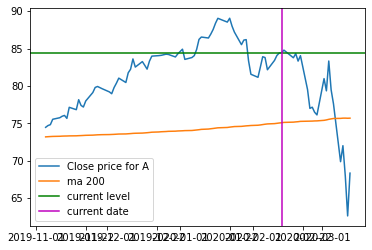

1


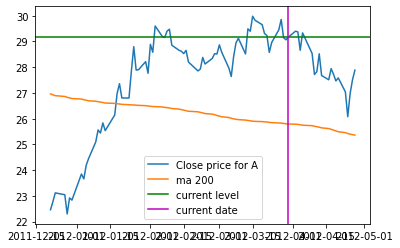

2


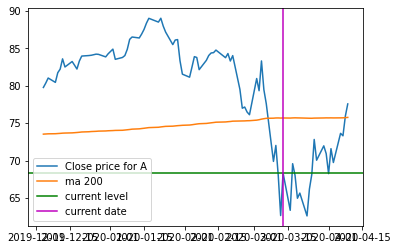

In [ ]:
for c in [0,1,2]:
    selection = df_y[df_y.relative_future_gain == c].values[5]
    print(c)
    plotter(df, selection[2],
            pd.to_datetime(selection[1])-timedelta(days=100),
            pd.to_datetime(selection[1])+timedelta(days=30),
            pd.to_datetime(selection[1]))

0


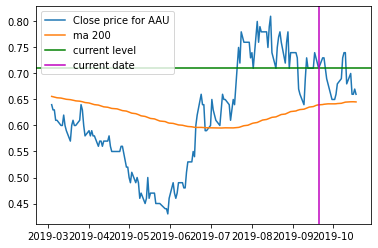

1


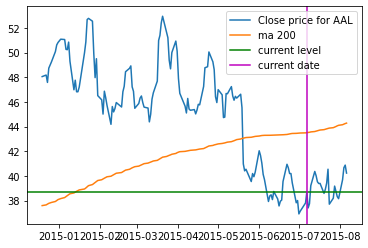

2


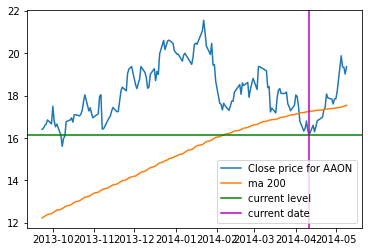

In [ ]:
for c in [0,1,2]:
    selection = df_y[df_y.relative_future_gain == c].values[500]
    print(c)
    plotter(df, selection[2],
            pd.to_datetime(selection[1])-timedelta(days=200),
            pd.to_datetime(selection[1])+timedelta(days=30),
            pd.to_datetime(selection[1]))

In [ ]:
X_train, X_test, y_full_train, y_full_test = train_test_split(x, y_full, test_size=0.33, random_state=42)
y_train = y_full_train[:,0]
y_test = y_full_test[:,0]

*Benchmark* model for shares


# Tree Model

In [ ]:
steps = [
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    ("clf", DecisionTreeClassifier(max_depth=10, min_samples_split=3)),
]
time_series_tree = Pipeline(steps)

In [ ]:
time_series_tree.fit(X_train, y_train)
print(time_series_tree.score(X_test, y_test))
print(time_series_tree.score(X_train, y_train))


0.753951800984711
0.7931205028797524


In [ ]:
predictions_train_tree, predictions_train_prob_tree, predictions_test_tree, predictions_test_prob_tree = metrics_calculations(time_series_tree, X_train, X_test, y_train, y_test)

confusion matrix on the test sample [[  189  2418   350]
 [  299 22238   618]
 [  236  3675   849]]
confusion matrix on the train sample [[  961  4583   521]
 [  184 46006   657]
 [  243  6779  2745]]
cross entropy on the test sample 1.1876001606247375
cross entropy on the train sample 0.5712817018653324


In [ ]:
# from sklearn import tree
# text_representation = tree.export_text(time_series_tree[1])
# print(text_representation)


|--- feature_10 <= 0.12
|   |--- feature_1 <= 0.85
|   |   |--- feature_1 <= 0.72
|   |   |   |--- class: 1
|   |   |--- feature_1 >  0.72
|   |   |   |--- class: 1
|   |--- feature_1 >  0.85
|   |   |--- feature_16 <= 0.03
|   |   |   |--- class: 1
|   |   |--- feature_16 >  0.03
|   |   |   |--- class: 1
|--- feature_10 >  0.12
|   |--- feature_3 <= 0.76
|   |   |--- feature_25 <= -0.01
|   |   |   |--- class: 2
|   |   |--- feature_25 >  -0.01
|   |   |   |--- class: 1
|   |--- feature_3 >  0.76
|   |   |--- feature_16 <= 0.05
|   |   |   |--- class: 1
|   |   |--- feature_16 >  0.05
|   |   |   |--- class: 1



# Transformer test

[link text](https://)(it looks like working, really small overtraining, and it can detect gorwth in 50% cases. But it doesn't detect drop at all. Wow, it really detects some interesting drops and cosequent raises, TO DO, play with reweighting and different learning rate (smaller learning rate is beneficial))

I checked 5 example in forecast with highest ranking. Results are average. Maybe half got increase

Reducting drop our helped a lot. It might continue training from the checkpoint. Resulats are in the analysis


TO DO
- create update and live test
- remake realtive ratio: it easy to satysfy after the drop, each cut should be reweighed with the last value
- live test?
- adding seasons
- adding volume?
-


In [ ]:


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

In [ ]:
def transformer_format(X_train, X_test, y_train, y_test):
  X_train_transformer = np.expand_dims(X_train, axis=3)[:,0]
  X_test_transformer = np.expand_dims(X_test, axis=3)[:,0]
  y_test_transformer  = np.array(list(map(int, y_test)))
  y_train_transformer  = np.array(list(map(int, y_train)))
  return X_train_transformer, X_test_transformer, y_test_transformer, y_train_transformer

In [ ]:
X_train_transformer, X_test_transformer, y_test_transformer, y_train_transformer = transformer_format(X_train, X_test, y_train, y_test)
x_future_transformer = np.expand_dims(x_future, axis=3)[:,0]

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=2
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [ ]:
len(np.unique(y_train_transformer))

3

In [ ]:
# model.save('gdrive/MyDrive/richbich/transformers')


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers/assets


In [ ]:
# model = keras.models.load_model('gdrive/MyDrive/richbich/transformers')


In [ ]:
# model.save('gdrive/MyDrive/richbich/transformers_decay_learning_weights')


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_decay_learning_weights/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_decay_learning_weights/assets


In [ ]:
model = keras.models.load_model('gdrive/MyDrive/richbich/transformers_decay_learning_weights')


In [ ]:
# model.save('gdrive/MyDrive/richbich/transformers_decay_reweighted')


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_decay_reweighted/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_decay_reweighted/assets


In [ ]:
# model.save('gdrive/MyDrive/richbich/transformers_full_final')


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full_final/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full_final/assets


In [ ]:
model = keras.models.load_model('gdrive/MyDrive/richbich/transformers_full')


In [ ]:
input_shape = X_train_transformer.shape[1:]
n_classes=len(np.unique(y_train_transformer))
# weights = Counter(y_train_transformer)
# class_weight = {0: weights[1]/weights[0],
#                 1: 1.,
#                 2: weights[1]/weights[2]}


model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[32],
    mlp_dropout=0.05, # dropout of final layer
    dropout=0.05, # dropout of transformers
    n_classes=n_classes,
)


# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=50,
#     decay_rate=0.1)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["sparse_categorical_accuracy"],
)

# categorical_crossentropy
model.summary()
filepath = 'gdrive/MyDrive/richbich/transformers_full'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint,
             keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

model.fit(
    X_train_transformer,
    y_train_transformer,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    # class_weight=class_weight,
)

print(model.evaluate(X_test_transformer, y_test_transformer, verbose=1))
model.evaluate(X_train_transformer, y_train_transformer, verbose=1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 100, 1)      2           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 100, 1)      7169        ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 399s 126ms/step - loss: 0.9130 - sparse_categorical_accuracy: 0.6023 - val_loss: 0.8730 - val_sparse_categorical_accuracy: 0.6169
Epoch 2/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8750 - sparse_categorical_accuracy: 0.6153
Epoch 00002: sparse_categorical_accuracy improved from 0.60226 to 0.61527, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 386s 123ms/step - loss: 0.8750 - sparse_categorical_accuracy: 0.6153 - val_loss: 0.8725 - val_sparse_categorical_accuracy: 0.6207
Epoch 3/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8660 - sparse_categorical_accuracy: 0.6171
Epoch 00003: sparse_categorical_accuracy improved from 0.61527 to 0.61708, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 387s 123ms/step - loss: 0.8660 - sparse_categorical_accuracy: 0.6171 - val_loss: 0.8624 - val_sparse_categorical_accuracy: 0.6210
Epoch 4/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8601 - sparse_categorical_accuracy: 0.6181
Epoch 00004: sparse_categorical_accuracy improved from 0.61708 to 0.61815, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 386s 123ms/step - loss: 0.8601 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.8593 - val_sparse_categorical_accuracy: 0.6209
Epoch 5/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8590 - sparse_categorical_accuracy: 0.6186
Epoch 00005: sparse_categorical_accuracy improved from 0.61815 to 0.61858, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 396s 126ms/step - loss: 0.8590 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.8582 - val_sparse_categorical_accuracy: 0.6225
Epoch 6/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8558 - sparse_categorical_accuracy: 0.6197
Epoch 00006: sparse_categorical_accuracy improved from 0.61858 to 0.61969, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 385s 122ms/step - loss: 0.8558 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.8577 - val_sparse_categorical_accuracy: 0.6213
Epoch 7/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8548 - sparse_categorical_accuracy: 0.6201
Epoch 00007: sparse_categorical_accuracy improved from 0.61969 to 0.62013, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 386s 123ms/step - loss: 0.8548 - sparse_categorical_accuracy: 0.6201 - val_loss: 0.8565 - val_sparse_categorical_accuracy: 0.6229
Epoch 8/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8528 - sparse_categorical_accuracy: 0.6204
Epoch 00008: sparse_categorical_accuracy improved from 0.62013 to 0.62039, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 384s 122ms/step - loss: 0.8528 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.8564 - val_sparse_categorical_accuracy: 0.6241
Epoch 9/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8515 - sparse_categorical_accuracy: 0.6209
Epoch 00009: sparse_categorical_accuracy improved from 0.62039 to 0.62091, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 395s 126ms/step - loss: 0.8515 - sparse_categorical_accuracy: 0.6209 - val_loss: 0.8560 - val_sparse_categorical_accuracy: 0.6239
Epoch 10/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8512 - sparse_categorical_accuracy: 0.6211
Epoch 00010: sparse_categorical_accuracy improved from 0.62091 to 0.62108, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 396s 126ms/step - loss: 0.8512 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.8564 - val_sparse_categorical_accuracy: 0.6243
Epoch 11/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8501 - sparse_categorical_accuracy: 0.6217
Epoch 00011: sparse_categorical_accuracy improved from 0.62108 to 0.62168, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 396s 126ms/step - loss: 0.8501 - sparse_categorical_accuracy: 0.6217 - val_loss: 0.8556 - val_sparse_categorical_accuracy: 0.6249
Epoch 12/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8494 - sparse_categorical_accuracy: 0.6215
Epoch 00012: sparse_categorical_accuracy did not improve from 0.62168
3145/3145 [==============================] - 383s 122ms/step - loss: 0.8494 - sparse_categorical_accuracy: 0.6215 - val_loss: 0.8589 - val_sparse_categorical_accuracy: 0.6221
Epoch 13/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8494 - sparse_categorical_accuracy: 0.6220
Epoch 00013: sparse_categorical_accuracy improved from 0.62168 to 0.62202, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 388s 123ms/step - loss: 0.8494 - sparse_categorical_accuracy: 0.6220 - val_loss: 0.8554 - val_sparse_categorical_accuracy: 0.6255
Epoch 14/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8481 - sparse_categorical_accuracy: 0.6225
Epoch 00014: sparse_categorical_accuracy improved from 0.62202 to 0.62254, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 397s 126ms/step - loss: 0.8481 - sparse_categorical_accuracy: 0.6225 - val_loss: 0.8552 - val_sparse_categorical_accuracy: 0.6258
Epoch 15/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8483 - sparse_categorical_accuracy: 0.6224
Epoch 00015: sparse_categorical_accuracy did not improve from 0.62254
3145/3145 [==============================] - 383s 122ms/step - loss: 0.8483 - sparse_categorical_accuracy: 0.6224 - val_loss: 0.8547 - val_sparse_categorical_accuracy: 0.6258
Epoch 16/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8475 - sparse_categorical_accuracy: 0.6223
Epoch 00016: sparse_categorical_accuracy did not improve from 0.62254
3145/3145 [==============================] - 383s 122ms/step - loss: 0.8475 - sparse_categorical_accuracy: 0.6223 - val_loss: 0.8545 - val_sparse_categorical_accuracy: 0.6250
Epoch 17/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8467 - sparse_categorica

INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 397s 126ms/step - loss: 0.8467 - sparse_categorical_accuracy: 0.6227 - val_loss: 0.8549 - val_sparse_categorical_accuracy: 0.6267
Epoch 18/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8463 - sparse_categorical_accuracy: 0.6226
Epoch 00018: sparse_categorical_accuracy did not improve from 0.62266
3145/3145 [==============================] - 393s 125ms/step - loss: 0.8463 - sparse_categorical_accuracy: 0.6226 - val_loss: 0.8533 - val_sparse_categorical_accuracy: 0.6262
Epoch 19/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8458 - sparse_categorical_accuracy: 0.6226
Epoch 00019: sparse_categorical_accuracy did not improve from 0.62266
3145/3145 [==============================] - 393s 125ms/step - loss: 0.8458 - sparse_categorical_accuracy: 0.6226 - val_loss: 0.8555 - val_sparse_categorical_accuracy: 0.6261
Epoch 20/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8462 - sparse_categorica

INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 389s 124ms/step - loss: 0.8462 - sparse_categorical_accuracy: 0.6230 - val_loss: 0.8550 - val_sparse_categorical_accuracy: 0.6259
Epoch 21/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8455 - sparse_categorical_accuracy: 0.6234
Epoch 00021: sparse_categorical_accuracy improved from 0.62305 to 0.62339, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 398s 126ms/step - loss: 0.8455 - sparse_categorical_accuracy: 0.6234 - val_loss: 0.8532 - val_sparse_categorical_accuracy: 0.6256
Epoch 22/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8449 - sparse_categorical_accuracy: 0.6237
Epoch 00022: sparse_categorical_accuracy improved from 0.62339 to 0.62370, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 398s 127ms/step - loss: 0.8449 - sparse_categorical_accuracy: 0.6237 - val_loss: 0.8539 - val_sparse_categorical_accuracy: 0.6262
Epoch 23/50
3145/3145 [==============================] - ETA: 0s - loss: 0.8449 - sparse_categorical_accuracy: 0.6238
Epoch 00023: sparse_categorical_accuracy improved from 0.62370 to 0.62382, saving model to gdrive/MyDrive/richbich/transformers_full


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/richbich/transformers_full/assets


3145/3145 [==============================] - 387s 123ms/step - loss: 0.8449 - sparse_categorical_accuracy: 0.6238 - val_loss: 0.8547 - val_sparse_categorical_accuracy: 0.6250
Epoch 24/50
 143/3145 [>.............................] - ETA: 5:35 - loss: 0.8383 - sparse_categorical_accuracy: 0.6273

In [ ]:
y_test_predict = model.predict(X_test_transformer)
y_train_predict = model.predict(X_train_transformer)
y_test_predict_class = y_test_predict.argmax(axis=1)
y_train_predict_class = y_train_predict.argmax(axis=1)

In [ ]:
  # reduced drop out
  print('cross entropy on the test sample', metrics.log_loss(y_test_transformer, y_test_predict, eps=1e-15))
  print('cross entropy on the train sample', metrics.log_loss(y_train_transformer, y_train_predict, eps=1e-15))

cross entropy on the test sample 0.8415836720219955
cross entropy on the train sample 0.8385373034706471


In [ ]:
  # decay learning weights with full y_test
  print('cross entropy on the test sample', metrics.log_loss(y_test_transformer, y_test_predict, eps=1e-15))
  print('cross entropy on the train sample', metrics.log_loss(y_train_transformer, y_train_predict, eps=1e-15))

cross entropy on the test sample 0.8789226195432369
cross entropy on the train sample 0.8806341694428995


In [ ]:
  # full training
  print('cross entropy on the test sample', metrics.log_loss(y_test_transformer, y_test_predict, eps=1e-15))
  print('cross entropy on the train sample', metrics.log_loss(y_train_transformer, y_train_predict, eps=1e-15))

cross entropy on the test sample 0.8528959982622908
cross entropy on the train sample 0.8515803047334262


In [ ]:
  # reweighted?
  print('cross entropy on the test sample', metrics.log_loss(y_test_transformer, y_test_predict, eps=1e-15))
  print('cross entropy on the train sample', metrics.log_loss(y_train_transformer, y_train_predict, eps=1e-15))

cross entropy on the test sample 0.6373188766092409
cross entropy on the train sample 0.6360149512500127


In [ ]:
  print('cross entropy on the test sample', metrics.log_loss(y_test_transformer, y_test_predict, eps=1e-15))
  print('cross entropy on the train sample', metrics.log_loss(y_train_transformer, y_train_predict, eps=1e-15))

cross entropy on the test sample 0.738092270851514
cross entropy on the train sample 0.742190205958328


In [ ]:
  print('cross entropy on the test sample', metrics.log_loss(y_test_transformer, y_test_predict, eps=1e-15))
  print('cross entropy on the train sample', metrics.log_loss(y_train_transformer, y_train_predict, eps=1e-15))

cross entropy on the test sample 0.6731907490790628
cross entropy on the train sample 0.6739053792202415


In [ ]:
y_train_predict

array([[0.06307638, 0.8432734 , 0.09365023],
       [0.07156683, 0.82294834, 0.10548488],
       [0.07039494, 0.8273391 , 0.10226589],
       ...,
       [0.22628717, 0.35464197, 0.41907093],
       [0.08344429, 0.79056   , 0.12599565],
       [0.07509489, 0.8174181 , 0.10748698]], dtype=float32)

In [ ]:
  # reduced dropout
  print('confusion matrix on the test sample', metrics.confusion_matrix(y_test_transformer, y_test_predict.argmax(axis=1)))
  print('confusion matrix on the train sample', metrics.confusion_matrix(y_train_transformer, y_train_predict.argmax(axis=1)))

confusion matrix on the test sample [[   506  25596  21710]
 [   139 123250  11405]
 [   591  33429  31187]]
confusion matrix on the train sample [[  1147  51961  43961]
 [   237 250352  23398]
 [  1128  67951  62999]]


In [ ]:
  # full training
  print('confusion matrix on the test sample', metrics.confusion_matrix(y_test_transformer, y_test_predict.argmax(axis=1)))
  print('confusion matrix on the train sample', metrics.confusion_matrix(y_train_transformer, y_train_predict.argmax(axis=1)))

confusion matrix on the test sample [[   326  25717  21769]
 [    81 123284  11429]
 [   354  33649  31204]]
confusion matrix on the train sample [[   650  52221  44198]
 [   130 250206  23651]
 [   673  68438  62967]]


In [ ]:
  # reweighted?
  print('confusion matrix on the test sample', metrics.confusion_matrix(y_test_transformer, y_test_predict.argmax(axis=1)))
  print('confusion matrix on the train sample', metrics.confusion_matrix(y_train_transformer, y_train_predict.argmax(axis=1)))

confusion matrix on the test sample [[  977  1464   516]
 [ 3024 18872  1259]
 [ 1535  1899  1326]]
confusion matrix on the train sample [[ 2150  2771  1144]
 [ 5971 38271  2605]
 [ 3125  3887  2755]]


In [ ]:
  # faslter learning
  print('confusion matrix on the test sample', metrics.confusion_matrix(y_test_transformer, y_test_predict.argmax(axis=1)))
  print('confusion matrix on the train sample', metrics.confusion_matrix(y_train_transformer, y_train_predict.argmax(axis=1)))

confusion matrix on the test sample [[    2  2533   422]
 [    0 22758   397]
 [    0  3807   953]]
confusion matrix on the train sample [[    7  5156   902]
 [    3 46033   811]
 [    3  7750  2014]]


In [ ]:
  # basic
  print('confusion matrix on the test sample', metrics.confusion_matrix(y_test_transformer, y_test_predict.argmax(axis=1)))
  print('confusion matrix on the train sample', metrics.confusion_matrix(y_train_transformer, y_train_predict.argmax(axis=1)))

confusion matrix on the test sample [[    0  2754   203]
 [    0 22938   217]
 [    0  4238   522]]
confusion matrix on the train sample [[    1  5627   437]
 [    1 46450   396]
 [    0  8616  1151]]


In [ ]:
  print('confusion matrix on the test sample', metrics.confusion_matrix(y_test_transformer, y_test_predict.argmax(axis=1)))
  print('confusion matrix on the train sample', metrics.confusion_matrix(y_train_transformer, y_train_predict.argmax(axis=1)))

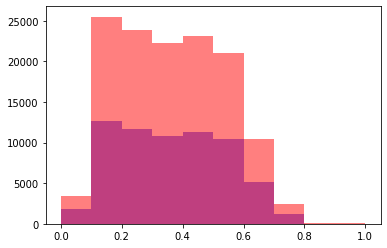

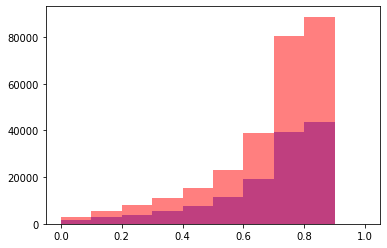

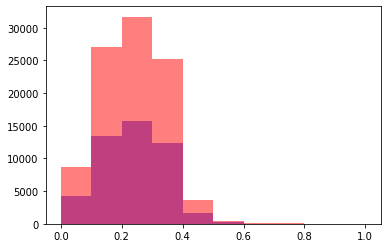

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(y_test_predict[y_test == '2'][:,2], alpha = 0.5, lw=3, color= 'b')
ax.hist(y_train_predict[y_train == '2'][:,2], alpha = 0.5, lw=3, color= 'r')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(y_test_predict[y_test == '1'][:,1], alpha = 0.5, lw=3, color= 'b')
ax.hist(y_train_predict[y_train == '1'][:,1], alpha = 0.5, lw=3, color= 'r')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(y_test_predict[y_test == '0'][:,0], alpha = 0.5, lw=3, color= 'b')
ax.hist(y_train_predict[y_train == '0'][:,0], alpha = 0.5, lw=3, color= 'r')
plt.show()

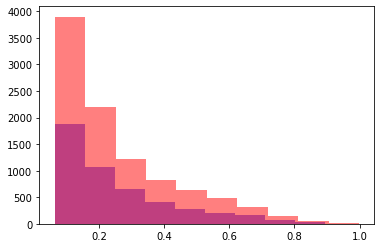

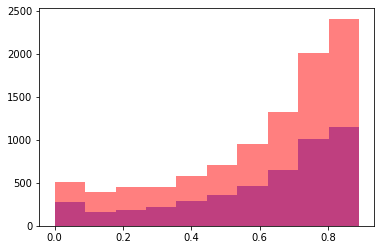

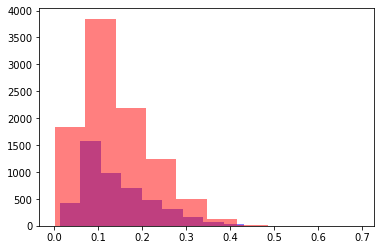

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(y_test_predict[y_test == '2'][:,2], alpha = 0.5, lw=3, color= 'b')
ax.hist(y_train_predict[y_train == '2'][:,2], alpha = 0.5, lw=3, color= 'r')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(y_test_predict[y_test == '2'][:,1], alpha = 0.5, lw=3, color= 'b')
ax.hist(y_train_predict[y_train == '2'][:,1], alpha = 0.5, lw=3, color= 'r')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(y_test_predict[y_test == '2'][:,0], alpha = 0.5, lw=3, color= 'b')
ax.hist(y_train_predict[y_train == '2'][:,0], alpha = 0.5, lw=3, color= 'r')
plt.show()

In [ ]:
# true positive
def example_plots(y_proba, y, X, Truth, Prediction):
  high_score = y[y_proba[:,Prediction] > 0.7]
  example_test = X[y_proba[:,Prediction] > 0.7]
  example_test = example_test[high_score[:,0]== Truth]
  print(f'found examples for prediction {Prediction} and Truth {Truth}')
  print(len(example_test))
  high_score = high_score[high_score[:,0]== Truth]
  high_score = high_score[0:5,1:3:1]


  for example in high_score:
    print(example)
    print()
    plotter(df, example[0],
            pd.to_datetime(example[1])-timedelta(days=200),
            pd.to_datetime(example[1])+timedelta(days=40),
            pd.to_datetime(example[1]))

In [ ]:
# found examples for prediction 2 and Truth 2 46
# found examples for prediction 2 and Truth 0 19

In [ ]:
example_plots(y_test_predict, y_full_test, X_test, '2', 2)

IndexError: ignored

In [ ]:
y_test_predict.argmax(axis=1)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from collections import Counter

In [ ]:
len(y_train_transformer)

62679

In [ ]:
9767/62679

0.15582571515180524

In [ ]:
0.155*9767

1513.885

In [ ]:
Counter(y_train_transformer)

Counter({0: 6065, 1: 46847, 2: 9767})

In [ ]:
Counter(y_train)

Counter({'0': 6065, '1': 46847, '2': 9767})

In [ ]:
y_train_transformer

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
print(model.evaluate(X_test_transformer, y_test_transformer, verbose=1))
print(model.evaluate(X_train_transformer, y_train_transformer, verbose=1))

965/965 [==============================] - 14s 15ms/step - loss: 0.6732 - sparse_categorical_accuracy: 0.7599
[0.6731902956962585, 0.7599118947982788]
1959/1959 [==============================] - 28s 15ms/step - loss: 0.6739 - sparse_categorical_accuracy: 0.7595
[0.6739057898521423, 0.7594569325447083]


## Future predictions

In [ ]:
y_future_predict = model.predict(x_future_transformer)
y_test_predict_class = y_future_predict.argmax(axis=1)


In [ ]:
# true positive
def future_example_plots(y_proba, y, X, Prediction):
  # return y_proba[:,Prediction] > 0.7
  high_score = y[y_proba[:,Prediction] > 0.7]
  example_test = X[y_proba[:,Prediction] > 0.7]
  print(f'found examples for prediction {Prediction}')
  print(len(example_test))
  high_score = high_score[0:5,1:3:1]

  print(high_score)
  for example in high_score:
    print(example)
    plotter(df_future, example[0],
            pd.to_datetime(example[1])-timedelta(days=200),
            pd.to_datetime(example[1])+timedelta(days=5),
            pd.to_datetime(example[1]))

found examples for prediction 2
3
[['ANVS' '2021-12-01T00:00:00.000000000']
 ['ATER' '2021-11-30T00:00:00.000000000']
 ['CRTX' '2021-11-30T00:00:00.000000000']]
['ANVS' '2021-12-01T00:00:00.000000000']


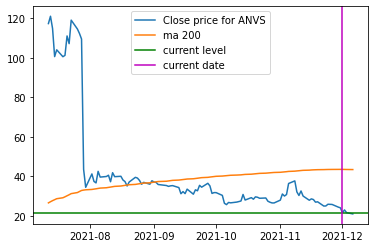

['ATER' '2021-11-30T00:00:00.000000000']


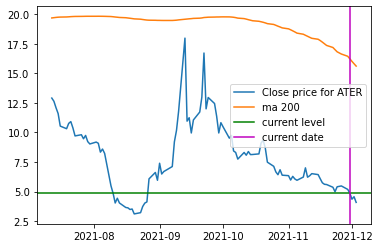

['CRTX' '2021-11-30T00:00:00.000000000']


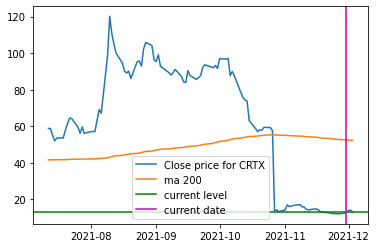

In [ ]:
future_example_plots(y_future_predict, y_future, x_future, 2)

found examples for prediction 2
3
[['ANVS' '2021-12-01T00:00:00.000000000']
 ['ATER' '2021-11-30T00:00:00.000000000']
 ['CRTX' '2021-11-30T00:00:00.000000000']]
['ANVS' '2021-12-01T00:00:00.000000000']


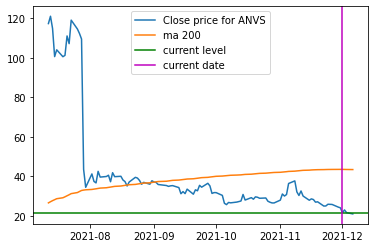

['ATER' '2021-11-30T00:00:00.000000000']


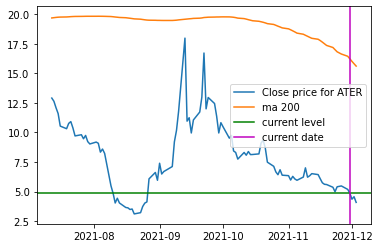

['CRTX' '2021-11-30T00:00:00.000000000']


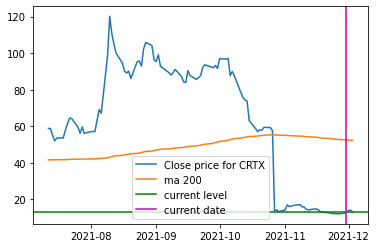

In [ ]:
future_example_plots(y_future_predict, y_future, x_future, 2)

In [ ]:
test

In [ ]:
len(y_full_test)

30872

In [ ]:
y_full_test

array([['1', 'SEDG', '2016-11-18T00:00:00.000000000'],
       ['1', 'CQP', '2015-01-13T00:00:00.000000000'],
       ['1', 'EMN', '2020-07-08T00:00:00.000000000'],
       ...,
       ['1', 'IHG', '2017-05-17T00:00:00.000000000'],
       ['1', 'IMBBF', '2018-08-03T00:00:00.000000000'],
       ['1', 'AQN', '2013-04-18T00:00:00.000000000']], dtype='<U29')

In [ ]:
len(y_future)

2

In [ ]:
y_future

(array([['211.3000030517578', 'AAP', '2021-10-06T00:00:00.000000000'],
        ['337.29998779296875', 'ABMD', '2021-10-06T00:00:00.000000000'],
        ['53.290000915527344', 'AEM', '2021-10-06T00:00:00.000000000'],
        ['134.24000549316406', 'AFG', '2021-10-06T00:00:00.000000000'],
        ['125.62000274658205', 'AGCO', '2021-10-06T00:00:00.000000000'],
        ['161.10000610351562', 'AIZ', '2021-10-06T00:00:00.000000000'],
        ['222.3699951171875', 'ALB', '2021-10-06T00:00:00.000000000'],
        ['129.32000732421878', 'ALLE', '2021-10-06T00:00:00.000000000'],
        ['53.68999862670898', 'ALLY', '2021-10-06T00:00:00.000000000'],
        ['201.0800018310547', 'ALNY', '2021-10-06T00:00:00.000000000'],
        ['36.83000183105469', 'AMC', '2021-10-06T00:00:00.000000000'],
        ['115.1500015258789', 'AN', '2021-10-06T00:00:00.000000000'],
        ['75.76000213623047', 'ARES', '2021-10-06T00:00:00.000000000'],
        ['293.29998779296875', 'ARGX', '2021-10-06T00:00:00.000000

# New Section

In [ ]:
tsf = ComposableTimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

TypeError: ignored

In [ ]:
test_predict = tsf.predict_proba(X_test)

In [ ]:
tsf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [ ]:
test_predict[:,2]

array([0.08, 0.42, 0.18, ..., 0.15, 0.3 , 0.18])

(array([232., 469., 636., 640., 504., 361., 186.,  95.,  38.,  12.]),
 array([0.  , 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9 ]),
 <a list of 10 Patch objects>)

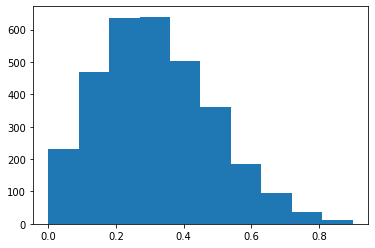

In [ ]:
plt.hist(test_predict[:,2][y_test == 2])

(array([5.447e+03, 3.193e+03, 1.716e+03, 1.186e+03, 5.960e+02, 3.470e+02,
        1.240e+02, 3.700e+01, 1.300e+01, 2.000e+00]),
 array([0.   , 0.076, 0.152, 0.228, 0.304, 0.38 , 0.456, 0.532, 0.608,
        0.684, 0.76 ]),
 <a list of 10 Patch objects>)

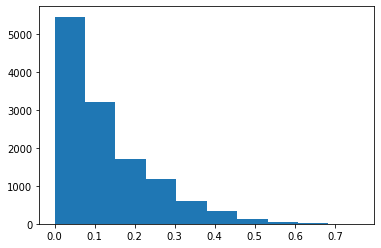

In [ ]:
plt.hist(test_predict[:,2][y_test == 1])

(array([179., 256., 357., 425., 379., 281., 157.,  66.,  26.,  10.]),
 array([0.   , 0.079, 0.158, 0.237, 0.316, 0.395, 0.474, 0.553, 0.632,
        0.711, 0.79 ]),
 <a list of 10 Patch objects>)

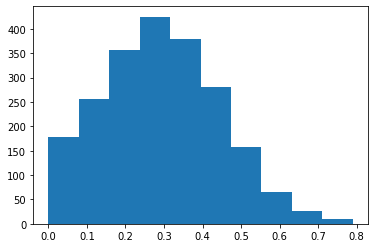

In [ ]:
plt.hist(test_predict[:,2][y_test == 0])

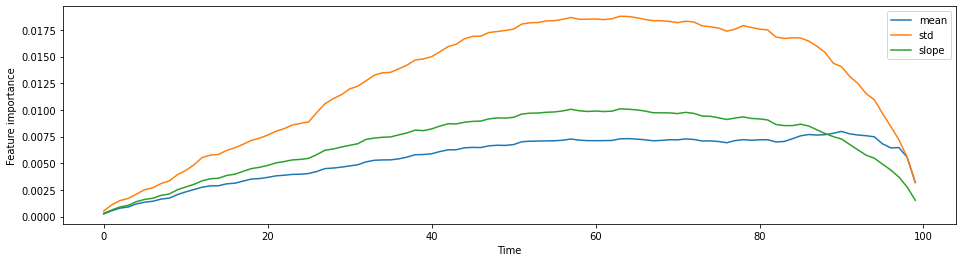

In [ ]:
fi = tsf.feature_importances_
# renaming _slope to slope.
fi.rename(columns={"_slope": "slope"}, inplace=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Feature importance");

*Benchmark* model

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


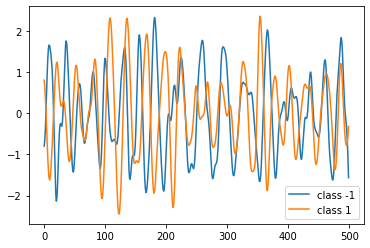

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()


(3601, 500)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [ ]:
x_train

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0


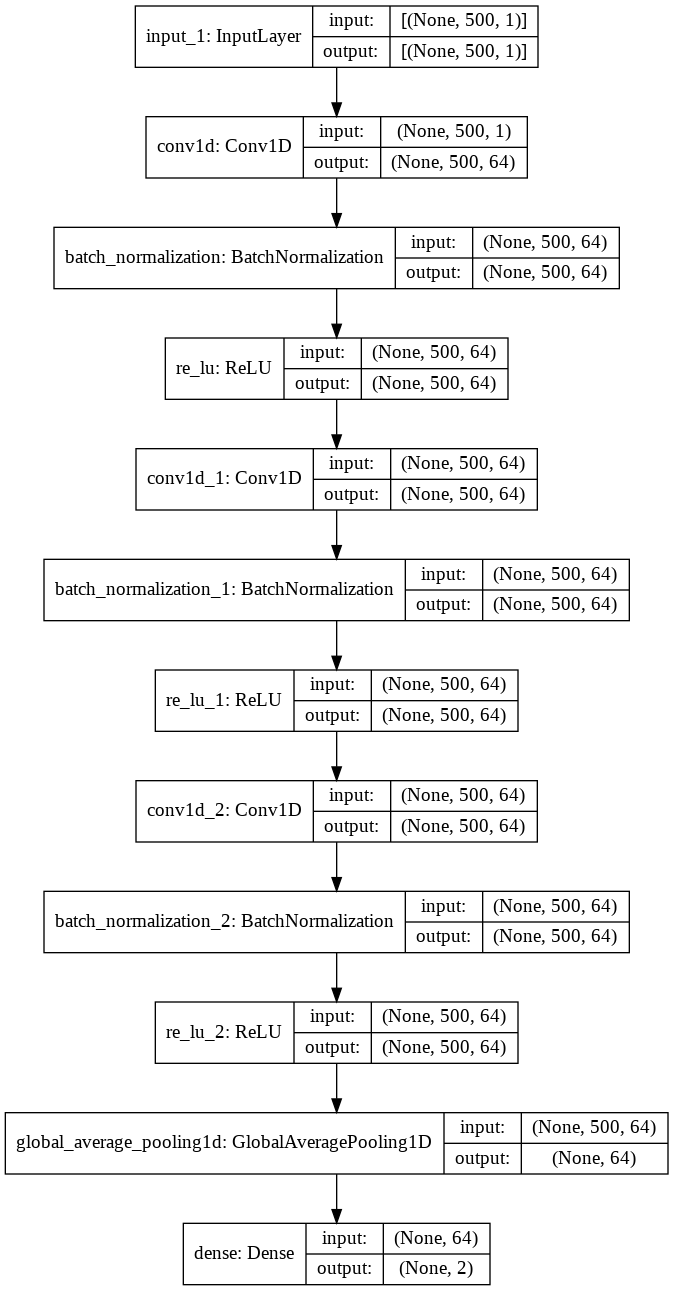

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
epochs = 20
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)


42/42 [==============================] - 1s 28ms/step - loss: 0.2706 - sparse_categorical_accuracy: 0.8909
Test accuracy 0.8909090757369995
Test loss 0.27063798904418945


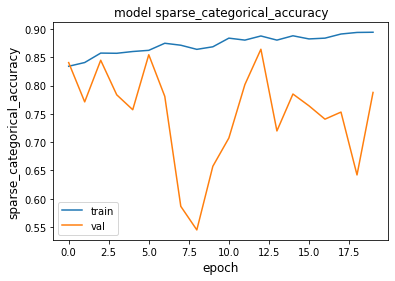

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


In [ ]:
!pip install sktime

     |████████████████████████████████| 5.8 MB 4.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 9.5 MB 36.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope

In [ ]:
x_train

In [ ]:


# binary target variable
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)



[0 1] [1846 1755]


In [ ]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor

In [ ]:
steps = [
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    ("clf", DecisionTreeClassifier()),
]
time_series_tree = Pipeline(steps)

In [ ]:
X_train = np.expand_dims(np.squeeze(x_train), axis=1)
X_test = np.expand_dims(np.squeeze(x_test), axis=1)

In [ ]:
X_train

array([[[-2.2684911 , -1.9243162 , -1.4612245 , ...,  0.06955051,
         -0.04785627, -0.20277423]],

       [[-0.0920256 , -0.09287315, -0.1299057 , ..., -1.423377  ,
         -1.1884021 , -0.93066682]],

       [[-1.4004939 , -1.2250255 , -0.98908249, ..., -0.97285656,
         -0.65455192, -0.31043243]],

       ...,

       [[ 0.42264061,  0.33757879,  0.2433211 , ..., -3.0924816 ,
         -3.0924816 , -2.9545435 ]],

       [[ 0.43219686,  0.35433578,  0.2563533 , ...,  1.1836875 ,
          1.5511218 ,  1.8398202 ]],

       [[ 0.23289829,  0.16649513,  0.11186558, ..., -0.77445172,
         -1.4337738 , -1.9800693 ]]])

In [ ]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.5848484848484848

In [ ]:
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

TypeError: ignored

In [ ]:
tsf = ComposableTimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.7916666666666666

In [ ]:
tsf.predict_proba(X_test)

array([[0.87, 0.13],
       [0.7 , 0.3 ],
       [0.76, 0.24],
       ...,
       [0.39, 0.61],
       [0.54, 0.46],
       [0.53, 0.47]])

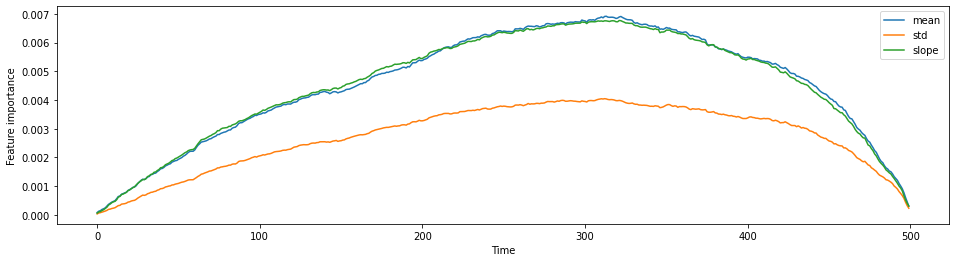

In [ ]:
fi = tsf.feature_importances_
# renaming _slope to slope.
fi.rename(columns={"_slope": "slope"}, inplace=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Feature importance");